## Environmental Setup

> Since it is impractical to download our dataset of sheer size in a reasonable time frame, we decided to have our implementations utilize the shared folder, which can be accessible from the mounted google drive. Therefore, for reproducibility, it is **IMPORTANT** to
1. Visit this [drive folder](https://drive.google.com/drive/folders/1VMn57KmlJ20DlviBlGufDC7vgdWIR9ni?usp=sharing).
2. Once visited, it'll show up in 'Shared with me' section in your google drive, from which you can add the shortcut to your drive.
3. Then, the shortcut should have the path, `drive/MyDrive/CS471 Project`.

Mount Google Drive to the Colab VM and install necessary modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/CS471 Project

/content/drive/.shortcut-targets-by-id/1VMn57KmlJ20DlviBlGufDC7vgdWIR9ni/CS471 Project


In [ ]:
!pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 27.4 MB/s eta 0:00:00


In [ ]:
import os
import pickle
import torch
import random
import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal
from pathlib import Path
import argparse
from distutils.dir_util import copy_tree
import shutil
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from random import shuffle, randrange, choices
from nilearn import image, maskers, datasets, plotting
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

## Visualising

Let's visualize what a fMRI image looks like.

Download and visualize the Schaefer 2018 atlas with 200 parcels on a z-axis slice. Schaefer 2018 atlas provides provides a labeling of cortical voxels in the MNI152 space, see [Schaefer et al](https://academic.oup.com/cercor/article/28/9/3095/3978804). Different versions of the atlas are available, but this version uses 400 number of rois.

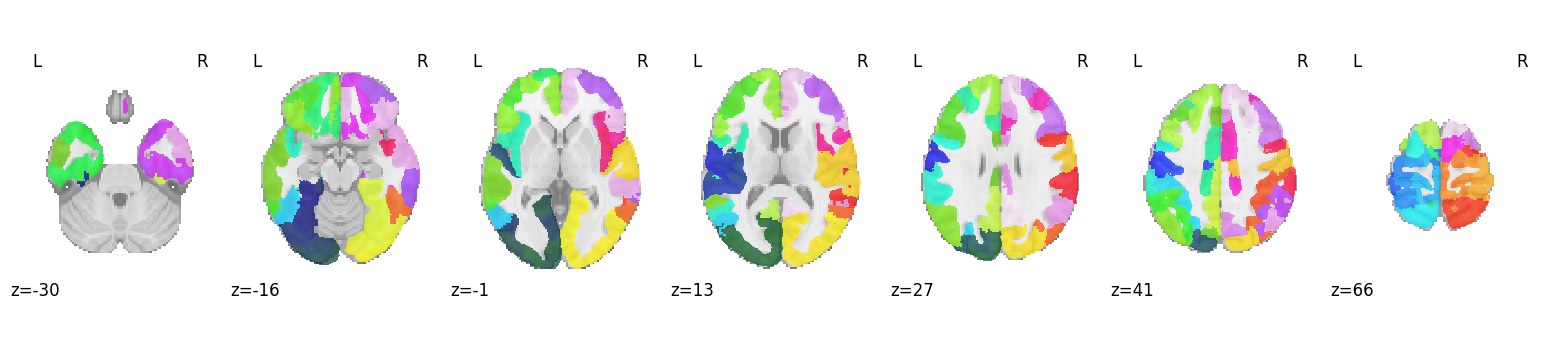

In [ ]:
roi = datasets.fetch_atlas_schaefer_2018(data_dir=os.path.join("./Dataset", 'roi'))
plotting.plot_roi(roi['maps'], display_mode="z")

Visualize how a fMRI image of a subject's brain looks like during a language task.

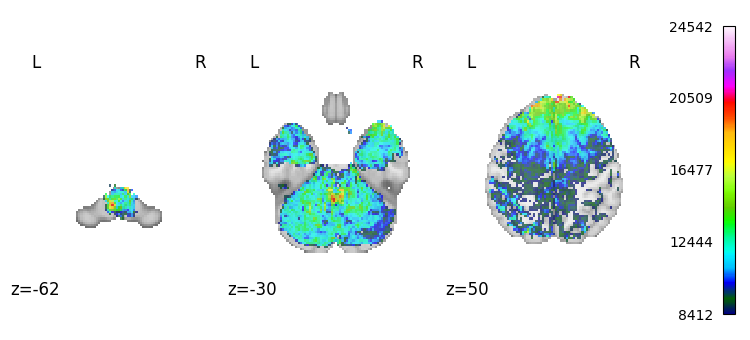

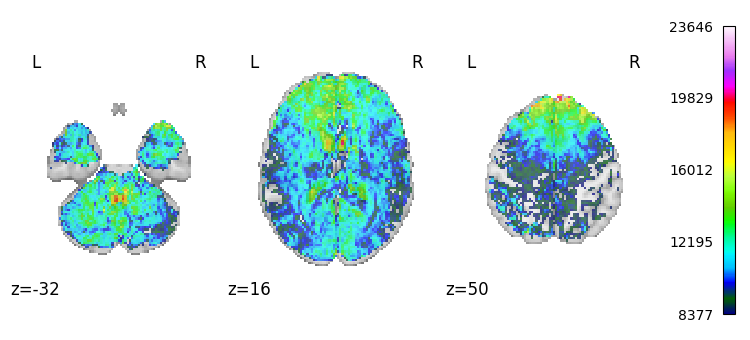

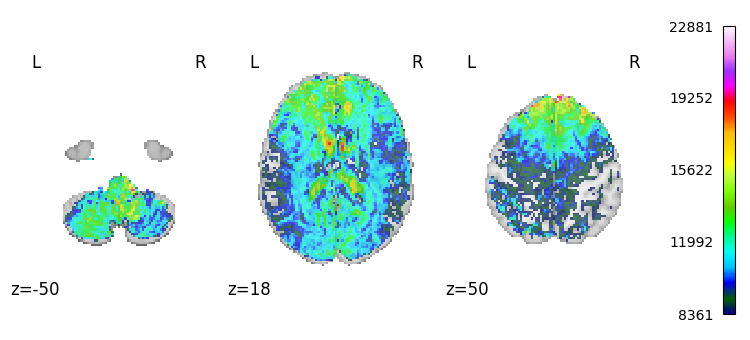

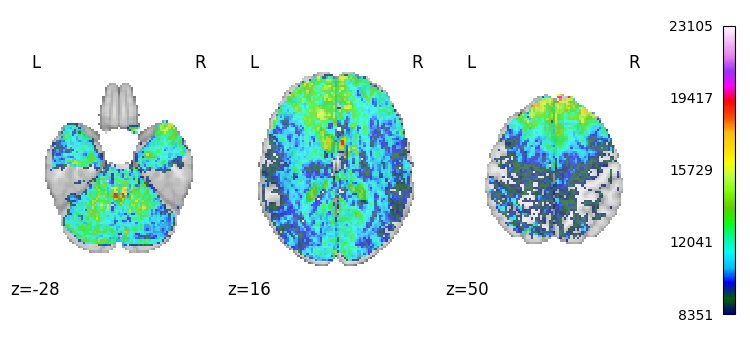

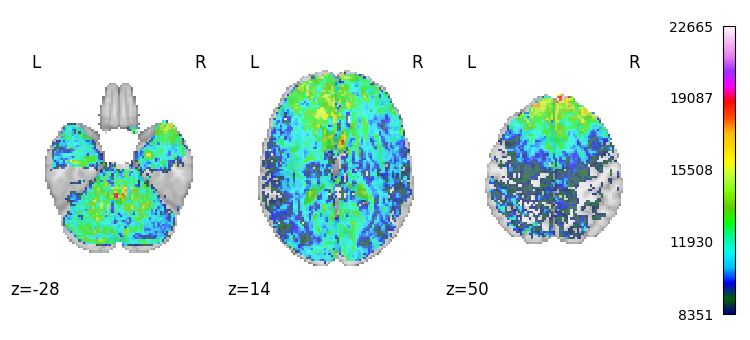

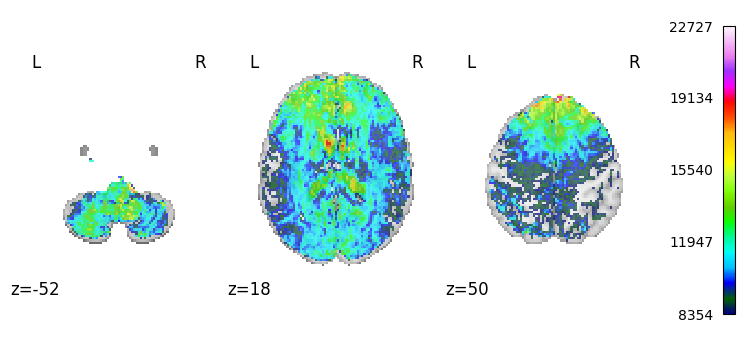

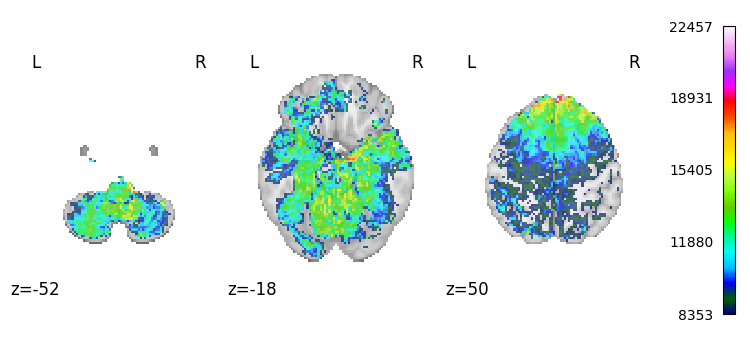

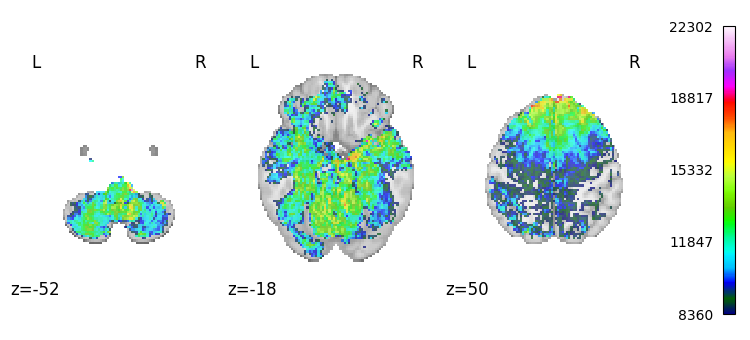

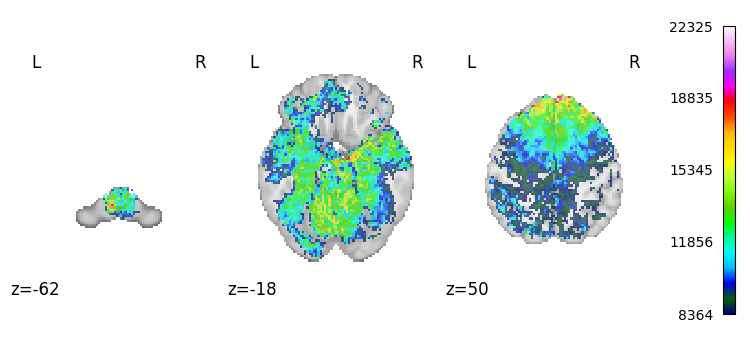

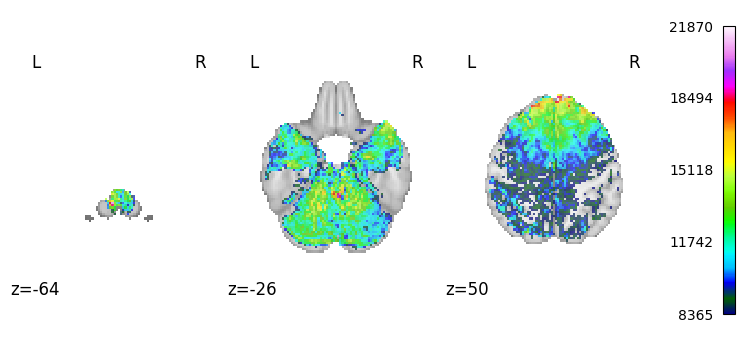

In [ ]:
language_img_path = './Dataset/img/TASK/LANGUAGE/100307.nii.gz'
subject_num = 10
count = 0
for img in image.iter_img(language_img_path):
  if count == subject_num:
    break
  plotting.plot_roi(img, threshold="auto", display_mode="z", cut_coords=3, colorbar=True)
  count += 1
# timestamps: 316

See the shape of the `timeseries` tensor, `# timestamps x # rois`

In [ ]:
roi_masker = maskers.NiftiLabelsMasker(image.load_img(roi['maps']))
timeseries = roi_masker.fit_transform(image.load_img(os.path.join('./Dataset', 'img', 'TASK', 'LANGUAGE', '100307.nii.gz')))
timeseries.shape

(316, 400)

## Dataset Loading

Construct the dataset from 50 fMRI images for 50 subjects.  

In [ ]:
class DatasetHCPLanguage(torch.utils.data.Dataset):
    def __init__(self, sourcedir, roi, dynamic_length=None, k_fold=None, smoothing_fwhm=None):
        super().__init__()
        self.filename = 'hcp-task'
        self.filename += f'_roi-{roi}'
        if smoothing_fwhm is not None: self.filename += f'_fwhm-{smoothing_fwhm}'

        self.roi = datasets.fetch_atlas_schaefer_2018(data_dir=os.path.join(sourcedir, 'roi'))

        task_timepoints = {'LANGUAGE': 316}
        self.sourcedir = sourcedir
        self.dynamic_length = dynamic_length
        self.task_list = list(task_timepoints.keys())
        self.task_list.sort()
        print(self.task_list)

        if os.path.isfile(os.path.join(sourcedir, f'{self.filename}.pth')):
            self.timeseries_list, self.label_list = torch.load(os.path.join(sourcedir, f'{self.filename}.pth'))
        else:
            roi_masker = maskers.NiftiLabelsMasker(image.load_img(self.roi['maps']))
            self.timeseries_list = []
            self.label_list = []
            for task in self.task_list:
                img_list = [f for f in os.listdir(os.path.join(sourcedir, 'img', 'TASK', task)) if f.endswith('nii.gz')]
                print(str(len(img_list))+'iii')
                img_list.sort()
                for subject in tqdm(img_list, ncols=60, desc=f'prep:{task.lower()[:3]}'):
                    timeseries = roi_masker.fit_transform(image.load_img(os.path.join(self.sourcedir, 'img', 'TASK', task, subject)))
                    if not len(timeseries)==task_timepoints[task]:
                        print(f"short timeseries: {len(timeseries)}")
                        continue
                    self.timeseries_list.append(timeseries)
                    self.label_list.append(task)
            torch.save((self.timeseries_list, self.label_list), os.path.join(sourcedir, f'{self.filename}.pth'))
        if k_fold is not None:
          if k_fold > 1:
              self.k_fold = StratifiedKFold(k_fold, shuffle=True, random_state=0)
              self.k = None
          else:
              self.k_fold = None
        else:
          self.k_fold=None
          self.k=None
        self.num_nodes = self.timeseries_list[0].shape[1]
        self.num_classes = len(set(self.label_list))
        self.train = None

    def __len__(self):
        return len(self.fold_idx) if self.k is not None else len(self.timeseries_list)


    def set_fold(self, fold, train=True):
        if not self.k_fold:
            return
        self.k = fold
        train_idx, test_idx = list(self.k_fold.split(self.timeseries_list, self.label_list))[fold]
        if train:
            random.shuffle(train_idx)
            self.fold_idx = train_idx
            self.train = True
        else:
            self.fold_idx = test_idx
            self.train = False

    def __getitem__(self, idx):
        if self.k_fold is not None:
          timeseries = self.timeseries_list[self.fold_idx[idx]]
        else:
          timeseries=self.timeseries_list[idx]
        timeseries = (timeseries - np.mean(timeseries, axis=0, keepdims=True)) / (np.std(timeseries, axis=0, keepdims=True) + 1e-9)
        if not self.dynamic_length is None:
            if self.train:
                #print(len(timeseries))
                sampling_init = random.randrange(len(timeseries)-self.dynamic_length)
                timeseries = timeseries[sampling_init:sampling_init+self.dynamic_length]
        task = self.label_list[idx]

        for task_idx, _task in enumerate(self.task_list):
            if task == _task:
                label = task_idx
        return {'timeseries': torch.tensor(timeseries, dtype=torch.float32), 'label': torch.tensor(label)}

In [ ]:
random.seed(169929)
dataset = DatasetHCPLanguage("./Dataset", roi='schaefer', k_fold=None)
print(len(dataset))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

['LANGUAGE']
50


## Constructing Dynamic FC (Adjacency Matrix)

Let's construct dynamic functional connectivity (FC) for each window of the entire timeseries for 50 subjects. the contents of which will be stored in a single matrix, whose shape is `#subject x #window x #node x #node = 40 x 50 x 400 x 400`.



In [ ]:
# corrcoef based on
# https://github.com/pytorch/pytorch/issues/1254
def corrcoef(x):
    '''
    Compute cross covariance from a window of timeseries
    '''
    mean_x = torch.mean(x, 1, keepdim=True)
    xm = x.sub(mean_x.expand_as(x))
    c = xm.mm(xm.t())
    c = c / (x.size(1) - 1)
    d = torch.diag(c)
    stddev = torch.pow(d, 0.5)
    c = c.div(stddev.expand_as(c))
    c = c.div(stddev.expand_as(c).t())
    c = torch.clamp(c, -1.0, 1.0)
    return c

def get_fc(matrix, sampling_point, window_size, self_loop):
    '''
    Get functional connectivity (FC) of a window of timeseries
    '''
    fc = corrcoef(matrix[sampling_point:sampling_point+window_size].T)
    if not self_loop: fc-= torch.eye(fc.shape[0])
    return fc


def process_dynamic_fc(timeseries, window_size, window_stride, dynamic_length=None, sampling_init=None, self_loop=True):
    '''
    Compute functional connectivity (FC) for each window of the entire timeseries
    input shape: [#subject x #window x #node]
    output shape: [#subject x #window x #node x #node]
    '''

    if dynamic_length is None:
        dynamic_length = timeseries.shape[1]
        sampling_init = 0
    else:
        if isinstance(sampling_init, int):
            assert timeseries.shape[1] > sampling_init + dynamic_length
    assert sampling_init is None or isinstance(sampling_init, int)
    assert timeseries.ndim==3

    if sampling_init is None:
        sampling_init = randrange(timeseries.shape[1]-dynamic_length+1)

    # starting points for sliding window
    sampling_points = list(range(sampling_init, sampling_init+dynamic_length-window_size, window_stride))

    dynamic_list=[]
    for matrix in timeseries:
      fc_list = [get_fc(matrix, sampling_point, window_size, self_loop) for sampling_point in sampling_points]
      fc_tensor = torch.stack(fc_list, dim=0)
      dynamic_list.append(fc_tensor)
    dynamic_fc = torch.stack(dynamic_list, dim=0)

    return dynamic_fc, sampling_points

In [ ]:
top_percentile = 0.05
percentile = '5-percentile'

dyn_a_dir = "./Dynamic Data"
train_data_dir = f"./{percentile}-data/Train_Data_csv"
valid_data_dir=f"./{percentile}-data/Valid_Data_csv"
test_data_dir = f'./{percentile}-data/Test_Data_csv'
os.makedirs(dyn_a_dir, exist_ok=True)
os.makedirs(train_data_dir, exist_ok=True)
os.makedirs(valid_data_dir, exist_ok=True)
os.makedirs(test_data_dir, exist_ok=True)

In [ ]:
index=[i for i in range(50)]
shuffle(index)
trainIdx=index[0:30]
validIdx=index[30:40]
testIdx=index[40:50]

In [ ]:
def generate_dyn_a(mode):
    dyn_a_list=[]
    for i, x in enumerate(tqdm(dataloader)):
      # These parameter values yields exactly 50 FC matrices (timepoint = 7, 12, 17, ..., 257)
      dyn_a, sampling_points = process_dynamic_fc(x['timeseries'], window_size=50, window_stride=5, dynamic_length=300, sampling_init=7)
      dyn_a_list.append(dyn_a)

    # dyn_a_tensor: 50 x 50 x 400 x 400
    dyn_a_tensor = torch.stack(dyn_a_list, dim=1)
    dyn_a_tensor=dyn_a_tensor.squeeze(0)
    print(dyn_a_tensor.shape)
    if(mode=='train'):
      dyn_a_tensor=dyn_a_tensor[trainIdx]
      assert dyn_a_tensor.shape==(30,50,400,400)
    if(mode=='valid'):
      dyn_a_tensor=dyn_a_tensor[validIdx]
    if(mode=='test'):
      dyn_a_tensor=dyn_a_tensor[testIdx]
    torch.save(dyn_a_tensor, os.path.join(dyn_a_dir, f'dyn_a_tensor_{mode}.pt'))
    return sampling_points

print("Generating for training...")
sampling_points = generate_dyn_a('train')
torch.save(sampling_points, os.path.join(dyn_a_dir, 'sampling_points_train.pt'))

print("--------------------")

print("Generating for validation...")
sampling_points = generate_dyn_a('valid')
torch.save(sampling_points, os.path.join(dyn_a_dir, 'sampling_points_valid.pt'))

print ("-------------------")

print("Generating for testing...")
sampling_points = generate_dyn_a('test')
torch.save(sampling_points, os.path.join(dyn_a_dir, 'sampling_points_test.pt'))

Generating for training...


100%|██████████| 50/50 [00:08<00:00,  6.15it/s]


torch.Size([50, 50, 400, 400])
--------------------
Generating for validation...


100%|██████████| 50/50 [00:07<00:00,  6.90it/s]


torch.Size([50, 50, 400, 400])
-------------------
Generating for testing...


100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


torch.Size([50, 50, 400, 400])


From the FC matrix, obtain the adjacency matrix by thresholding the top n-percentile of the matrix as connected (1) and otherwise unconnected (0). Then, construct a csv file for each subject, where each row corresponds `source_node, destination_node, timestamp, edge_label, edge_features`

> It takes ~12 mins and ~3 mins for processing each training fold and testing fold respectively.




In [ ]:
def tensor2triplet(tensor, timepoints, threshold):
  assert tensor.dim() == 3

  timepoints = []
  srcNodes = []
  dstNodes = []

  for j in range(tensor.shape[0]):
    tensor2d = tensor[j]
    quantile = torch.quantile(tensor2d, threshold)
    adj2d = torch.where(tensor2d > quantile, 1.0, 0.0)
    argW = torch.argwhere(adj2d)


    for [u,v] in argW:
      timepoints.append(j)
      srcNodes.append(u.item())
      dstNodes.append(v.item())

  return timepoints, srcNodes, dstNodes

def save_dyn_a_to_csv(mode, data_dir):
  os.makedirs(data_dir, exist_ok=True)

  # Load dynamic adjacency tensor and sampling points
  dyn_a_tensor = torch.load(os.path.join(dyn_a_dir, f'dyn_a_tensor_{mode}.pt'))
  sampling_points = torch.load(os.path.join(dyn_a_dir, f'sampling_points_{mode}.pt'))

  # Save dynamic adjacency matrices as CSV
  for i, cube in enumerate(tqdm(dyn_a_tensor)):
    timepoints, src_nodes, dst_nodes = tensor2triplet(cube, sampling_points, 1 - top_percentile)
    data_dict = {'source': src_nodes, 'dest': dst_nodes, 'time_interval': timepoints}
    data_df = pd.DataFrame.from_dict(data_dict)
    data_df['edge_label'] = np.zeros(len(data_df))
    data_df['w'] = np.zeros(len(data_df))
    data_df.sort_values(by=['time_interval', 'source', 'dest'], inplace=True)
    data_df.to_csv(os.path.join(data_dir, f'{mode}_{i}.csv'), index=False)

In [ ]:
save_dyn_a_to_csv('train', train_data_dir)
save_dyn_a_to_csv('valid', valid_data_dir)
save_dyn_a_to_csv('test', test_data_dir)

100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


Allocate the relevant language scores for each fold.

In [ ]:
languageDf=pd.read_csv(os.path.join('./Dataset','language_score', 'language_score.csv'))

accDfIndex=languageDf.iloc[trainIdx, 1]
accDfID=languageDf.iloc[trainIdx, 0]
accDf=pd.concat([accDfID, accDfIndex], axis=1)
accDf.insert(0, 'Index', [i for i in range(accDf.shape[0])], True)
accDf.index.name="Index_Original"
accDf.to_csv(os.path.join(train_data_dir, 'Language_Task_Acc.csv'))

accDfIndex=languageDf.iloc[validIdx, 1]
accDfID=languageDf.iloc[validIdx, 0]
accDf=pd.concat([accDfID, accDfIndex], axis=1)
accDf.insert(0, 'Index', [i for i in range(accDf.shape[0])], True)
accDf.index.name="Index_Original"
accDf.to_csv(os.path.join(valid_data_dir, 'Language_Task_Acc.csv'))

accDfIndex=languageDf.iloc[testIdx, 1]
accDfID=languageDf.iloc[testIdx, 0]
accDf=pd.concat([accDfID, accDfIndex], axis=1)
accDf.insert(0, 'Index', [i for i in range(accDf.shape[0])], True)
accDf.index.name="Index_Original"
accDf.to_csv(os.path.join(test_data_dir, 'Language_Task_Acc.csv'))

## Preprocessing

Read the connectivity csv file for each subject and generate three files for each, a formatted csv file accepted by DyGFormer, raw node features numpy file, raw edge features numpy file.

In [ ]:

os.makedirs('/content/DG_data/Train', exist_ok=True)
shutil.copy(f'{percentile}-data/Train_Data_csv/Language_Task_Acc.csv', f'/content/DG_data/Train')

language_score_df = pd.read_csv(f'/content/DG_data/Train/Language_Task_Acc.csv')
for index, row in language_score_df.iterrows():
    subject_id = int(row.iloc[2])
    shutil.copy(f'{percentile}-data/Train_Data_csv/train_{index}.csv', f'/content/DG_data/Train')
    os.rename(f'/content/DG_data/Train/train_{index}.csv', f'/content/DG_data/Train/{index}.csv')


os.makedirs('/content/DG_data/Valid', exist_ok=True)
shutil.copy(f'{percentile}-data/Valid_Data_csv/Language_Task_Acc.csv', f'/content/DG_data/Valid')

language_score_df = pd.read_csv(f'/content/DG_data/Valid/Language_Task_Acc.csv')
for index, row in language_score_df.iterrows():
    subject_id = int(row.iloc[2])
    shutil.copy(f'{percentile}-data/Valid_Data_csv/valid_{index}.csv', f'/content/DG_data/Valid')
    os.rename(f'/content/DG_data/Valid/valid_{index}.csv', f'/content/DG_data/Valid/{index}.csv')


os.makedirs('/content/DG_data/Test', exist_ok=True)
shutil.copy(f'{percentile}-data/Test_Data_csv/Language_Task_Acc.csv', f'/content/DG_data/Test')

language_score_df = pd.read_csv(f'/content/DG_data/Test/Language_Task_Acc.csv')
for index, row in language_score_df.iterrows():
    subject_id = int(row.iloc[2])
    shutil.copy(f'{percentile}-data/Test_Data_csv/test_{index}.csv', f'/content/DG_data/Test')
    os.rename(f'/content/DG_data/Test/test_{index}.csv', f'/content/DG_data/Test/{index}.csv')

In [ ]:
def preprocess(dataset_name: str):
    """
    read the original data file and return the DataFrame that has columns ['u', 'i', 'ts', 'label', 'idx']
    :param dataset_name: str, dataset name
    :return:
    """
    u_list, i_list, ts_list, label_list = [], [], [], []
    feat_l = []
    idx_list = []

    with open(dataset_name) as f:
        # skip the first line
        s = next(f)
        previous_time = -1
        for idx, line in enumerate(f):
            e = line.strip().split(',')
            # user_id
            u = int(e[0])
            # item_id
            i = int(e[1])

            # timestamp
            ts = float(e[2])
            # check whether time in ascending order
            assert ts >= previous_time
            previous_time = ts
            # state_label
            label = float(e[3])

            # edge features
            feat = np.array([float(x) for x in e[4:]])

            u_list.append(u)
            i_list.append(i)
            ts_list.append(ts)
            label_list.append(label)
            # edge index
            idx_list.append(idx)

            feat_l.append(feat)
    return pd.DataFrame({'u': u_list,
                         'i': i_list,
                         'ts': ts_list,
                         'label': label_list,
                         'idx': idx_list}), np.array(feat_l)


def reindex(df: pd.DataFrame, bipartite: bool = True):
    """
    reindex the ids of nodes and edges
    :param df: DataFrame
    :param bipartite: boolean, whether the graph is bipartite or not
    :return:
    """
    new_df = df.copy()
    if bipartite:
        # check the ids of users and items
        assert (df.u.max() - df.u.min() + 1 == len(df.u.unique()))
        assert (df.i.max() - df.i.min() + 1 == len(df.i.unique()))
        assert df.u.min() == df.i.min() == 0

        # if bipartite, discriminate the source and target node by unique ids (target node id is counted based on source node id)
        upper_u = df.u.max() + 1
        new_i = df.i + upper_u

        new_df.i = new_i

    # make the id start from 1
    new_df.u += 1
    new_df.i += 1
    new_df.idx += 1

    return new_df


def preprocess_data(read_dir: str, save_dir: str, dataset_name: str, bipartite: bool = True, node_feat_dim: int = 172):
    """
    preprocess the data
    :param dataset_name: str, dataset name
    :param bipartite: boolean, whether the graph is bipartite or not
    :param node_feat_dim: int, dimension of node features
    :return:
    """
    gdrive_path = f'Preprocessed Data/{percentile}'
    os.makedirs(os.path.join(gdrive_path, save_dir, dataset_name), exist_ok=True)
    OUT_DF = os.path.join(gdrive_path, save_dir, dataset_name, 'ml_{}.csv'.format(dataset_name))
    OUT_FEAT = os.path.join(gdrive_path, save_dir, dataset_name, 'ml_{}.npy'.format(dataset_name))
    OUT_NODE_FEAT = os.path.join(gdrive_path, save_dir, dataset_name, 'ml_{}_node.npy'.format(dataset_name))
    PATH = '/content/DG_data/{}/{}.csv'.format(read_dir, dataset_name)

    df, edge_feats = preprocess(PATH)
    new_df = reindex(df, bipartite)

    # edge feature for zero index, which is not used (since edge id starts from 1)
    empty = np.zeros(edge_feats.shape[1])[np.newaxis, :]
    # Stack arrays in sequence vertically(row wise),
    edge_feats = np.vstack([empty, edge_feats])

    # node features with one additional feature for zero index (since node id starts from 1)
    max_idx = max(new_df.u.max(), new_df.i.max())
    node_feats = np.zeros((max_idx + 1, node_feat_dim))

    # print('number of nodes ', node_feats.shape[0] - 1)
    # print('number of node features ', node_feats.shape[1])
    # print('number of edges ', edge_feats.shape[0] - 1)
    # print('number of edge features ', edge_feats.shape[1])

    new_df.to_csv(OUT_DF)  # edge-list
    np.save(OUT_FEAT, edge_feats)  # edge features
    np.save(OUT_NODE_FEAT, node_feats)  # node features


In [ ]:

language_score_df = pd.read_csv(f'/content/DG_data/Train/Language_Task_Acc.csv')
for index, row in language_score_df.iterrows():
  subject_id = int(row.iloc[2])
  read_dir = f'Train'
  save_dir = f'Train'
  dataset = f'{index}'

  print(f"Preprocessing for subject {index}")
  preprocess_data(read_dir=read_dir, save_dir=save_dir, dataset_name=dataset, bipartite=False, node_feat_dim=172)

language_score_df = pd.read_csv(f'/content/DG_data/Valid/Language_Task_Acc.csv')
for index, row in language_score_df.iterrows():
  subject_id = int(row.iloc[2])
  read_dir = f'Valid'
  save_dir = f'Valid'
  dataset = f'{index}'

  print(f"Preprocessing for subject {index}")
  preprocess_data(read_dir=read_dir, save_dir=save_dir, dataset_name=dataset, bipartite=False, node_feat_dim=172)


language_score_df = pd.read_csv(f'/content/DG_data/Test/Language_Task_Acc.csv')
for index, row in language_score_df.iterrows():
  subject_id = int(row.iloc[2])
  read_dir = f'Test'
  save_dir = f'Test'
  dataset = f'{index}'

  print(f"Preprocessing for subject {index}")
  preprocess_data(read_dir=read_dir, save_dir=save_dir, dataset_name=dataset, bipartite=False, node_feat_dim=172)

Preprocessing for subject 0
Preprocessing for subject 1
Preprocessing for subject 2
Preprocessing for subject 3
Preprocessing for subject 4
Preprocessing for subject 5
Preprocessing for subject 6
Preprocessing for subject 7
Preprocessing for subject 8
Preprocessing for subject 9
Preprocessing for subject 10
Preprocessing for subject 11
Preprocessing for subject 12
Preprocessing for subject 13
Preprocessing for subject 14
Preprocessing for subject 15
Preprocessing for subject 16
Preprocessing for subject 17
Preprocessing for subject 18
Preprocessing for subject 19
Preprocessing for subject 20
Preprocessing for subject 21
Preprocessing for subject 22
Preprocessing for subject 23
Preprocessing for subject 24
Preprocessing for subject 25
Preprocessing for subject 26
Preprocessing for subject 27
Preprocessing for subject 28
Preprocessing for subject 29
Preprocessing for subject 0
Preprocessing for subject 1
Preprocessing for subject 2
Preprocessing for subject 3
Preprocessing for subject 4
